In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer, WordNetLemmatizer
import string

from sklearn.model_selection import train_test_split

from sklearn.decomposition import NMF

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD


from sklearn.cluster import MiniBatchKMeans, KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import itertools

import matplotlib.cm as cm

%matplotlib inline

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [208]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english')
        analyzer = super().build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc) if w.isalpha()])
    
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english')
        analyzer = super().build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc) if w.isalpha()])
    
class StemmedHashingVectorizer(HashingVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english')
        analyzer = super().build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc) if w.isalpha()])

scv = StemmedCountVectorizer(strip_accents='unicode',
                            stop_words=set(stopwords.words('english')) | set(string.punctuation) | {'abby', 'year', 'time'},
                             max_df=0.5,
                             min_df=2,
                             ngram_range=(1, 2),
                             max_features=2000)

stv = StemmedTfidfVectorizer(strip_accents='unicode',
                            stop_words=set(stopwords.words('english')) | set(string.punctuation) | {'abby', 'year', 'time'},
                             min_df=2,
                             max_df=0.5,
                             ngram_range=(1, 3),
                             max_features=10000)



In [30]:
qadf = pd.read_csv('s3://sagemaker-studio-961325086685-hvof0xrvm67/dearabby_qa.csv', index_col=0)

In [5]:
# qa_df = qadf[qadf['categories'].notna()]

In [6]:
new_df = qadf#qadf[qadf['categories'].notna()]

In [7]:
X = new_df['qa']
y = new_df['categories']


In [115]:
count_df = scv.fit_transform(X)

In [209]:
tfidf_df = stv.fit_transform(X)

In [210]:
pca_tv = PCA(n_components=2, random_state=42)
pca_X_tv = pca_tv.fit_transform(tfidf_df.toarray())

In [155]:
pca_cv = PCA(n_components=2, random_state=42)
pca_X_cv = pca_cv.fit_transform(count_df.toarray())

In [101]:
# scatter_plot_points_cv = pca.fit_transform(count_df.toarray())

In [12]:
def make_silhouette_plot(axs, X, n_clusters):

    ax1, ax2 = axs

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_jobs=-1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = (
            sample_silhouette_values[cluster_labels == i])

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    # ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    # colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=50, lw=0, alpha=0.7,
                c = colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    
    for i, center in enumerate(centers):
    #   c needs to be a 2-d array... 
        cmap = cm.get_cmap("Spectral")
        colour = np.asarray([cmap(float(i) / n_clusters)])
#         print(colour)
        ax2.scatter(center[0], center[1], marker='$%d$' % i, s=50,
                    c = colour)
        

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    return silhouette_avg

2
0.41416117537990316
3
0.4317207215903014
4
0.3755353331573786
5
0.3855504104712247
6
0.3519940825881253
7
0.36340347368159304
8
0.3678466864553494
9
0.3689672821448654
10
0.3522954905282818
11
0.351640747006716
12
0.3534920325541247


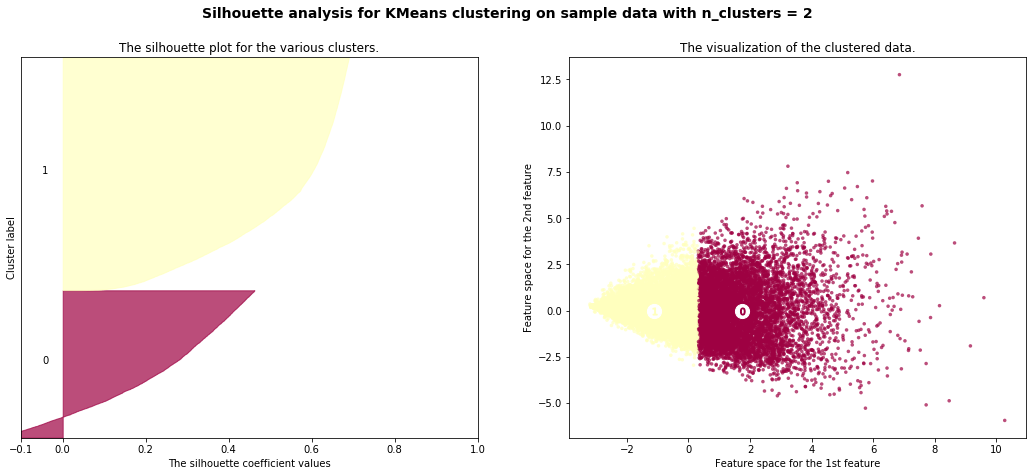

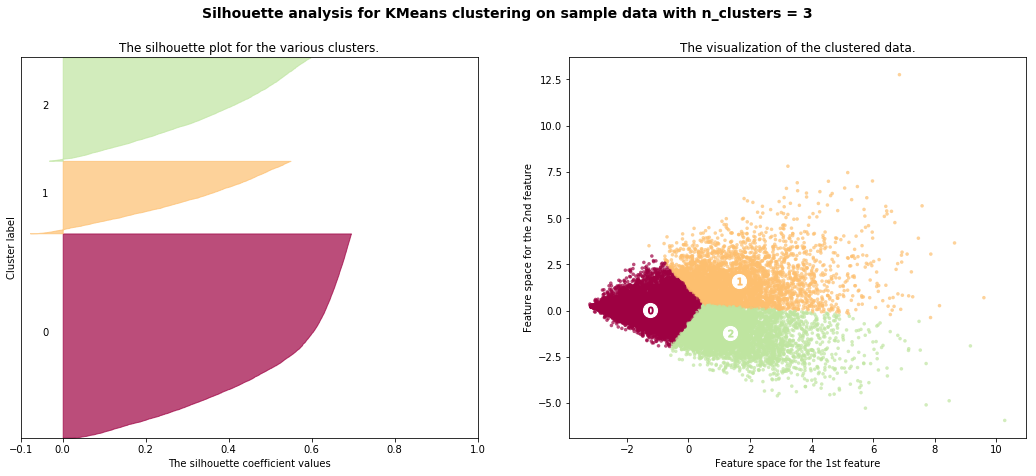

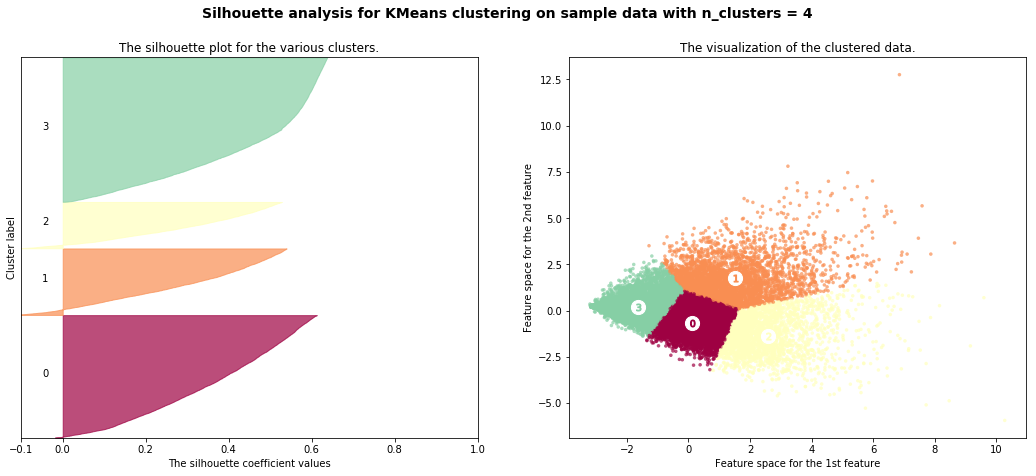

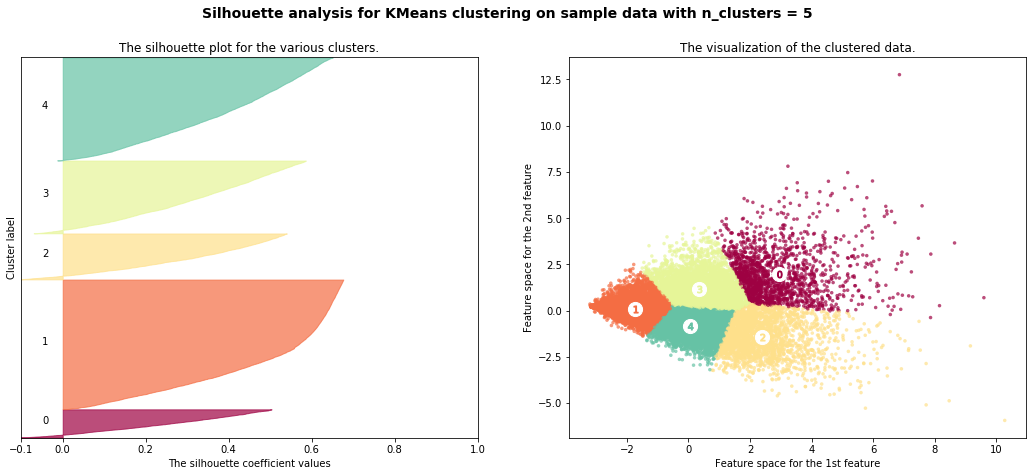

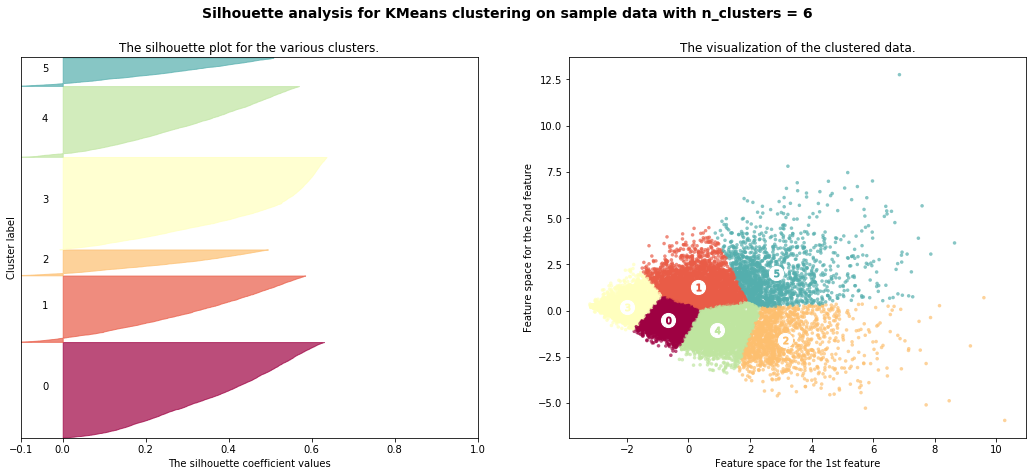

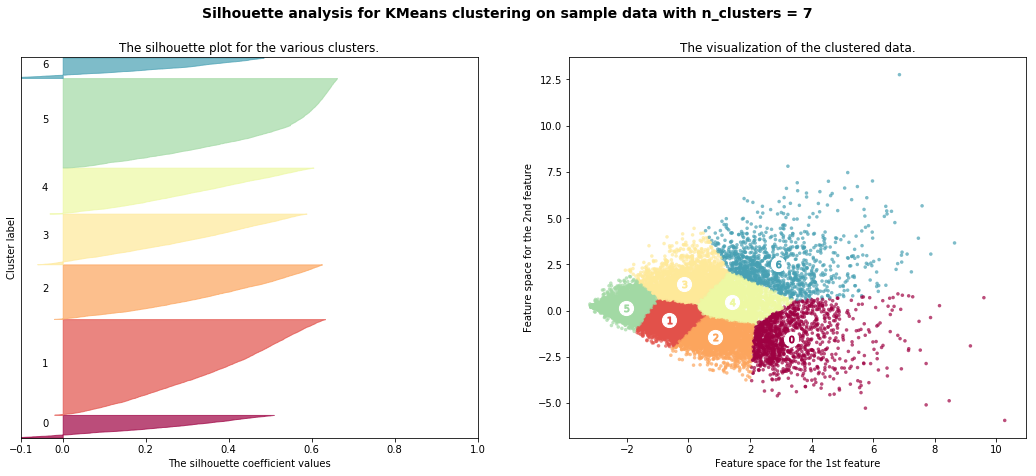

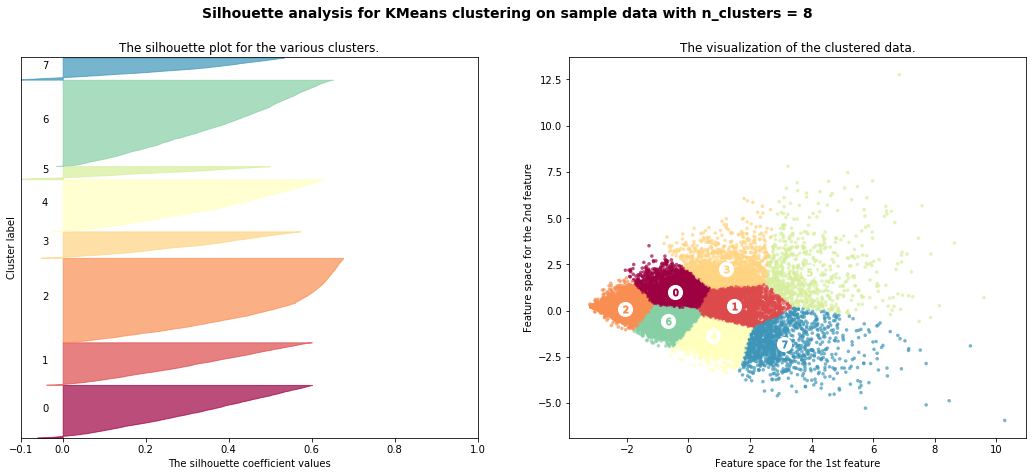

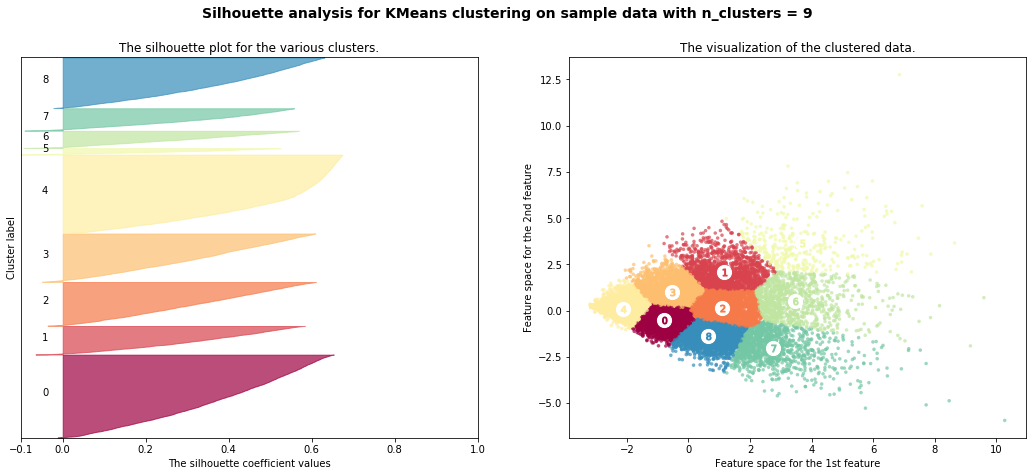

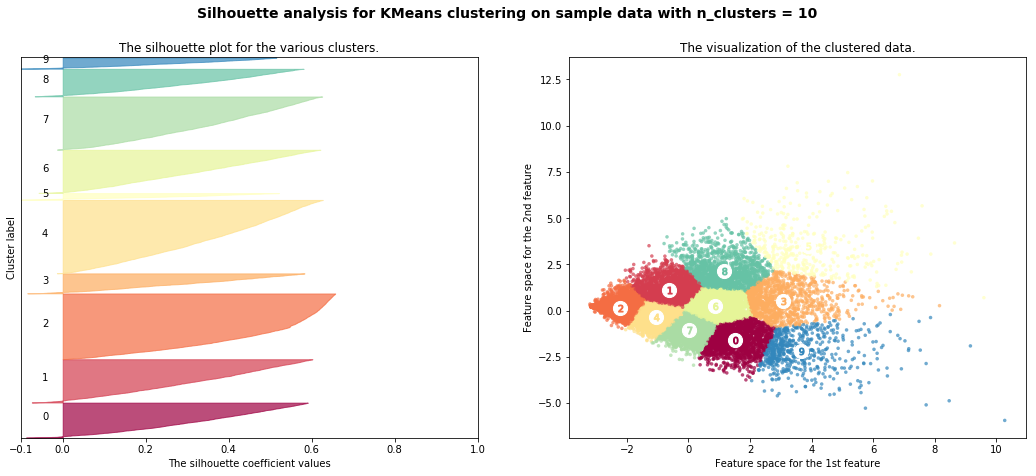

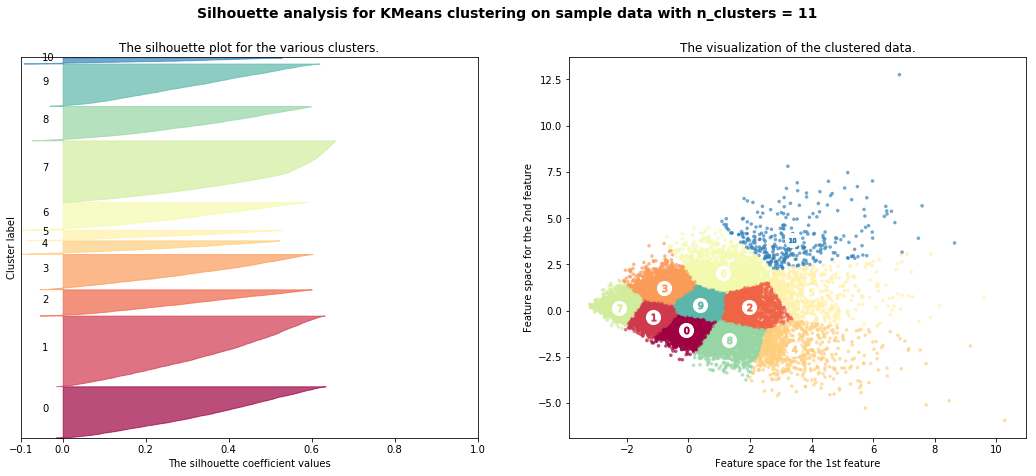

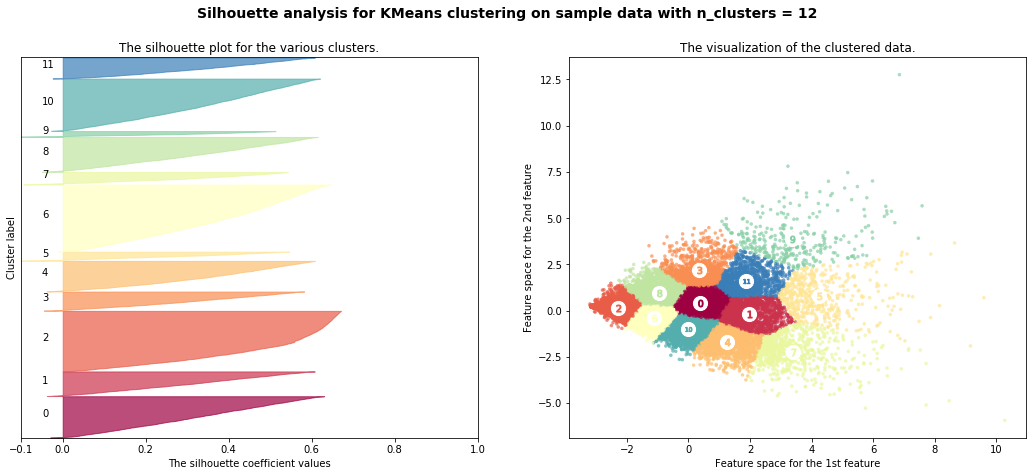

In [119]:
range_n_clusters = range(2, 13)
silhouette_scores_cv = np.empty(shape=11)

for idx, n_clusters in enumerate(range_n_clusters):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    score = make_silhouette_plot(axs, X = pca_X_cv, n_clusters=n_clusters)
    silhouette_scores_cv[idx] = score
    
    print(n_clusters)
    print(score)

Text(0, 0.5, 'silhouette score')

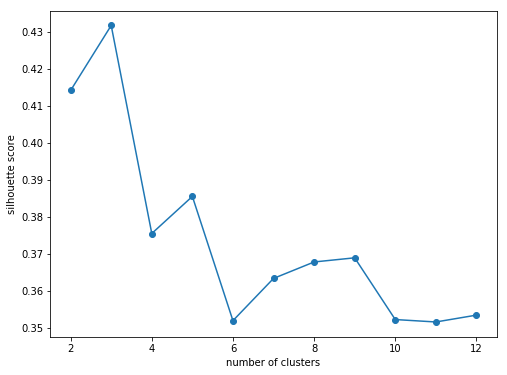

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range_n_clusters, silhouette_scores_cv, 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("silhouette score")


2
0.37291946951412436
3
0.3973118163201618
4
0.38753920527556357
5
0.3761713567279169
6
0.3603989437946918
7
0.3503044927490732
8
0.3540484046494959
9
0.3395839194322757
10
0.34188386707061263
11
0.3402717683714569
12
0.34252123278658714


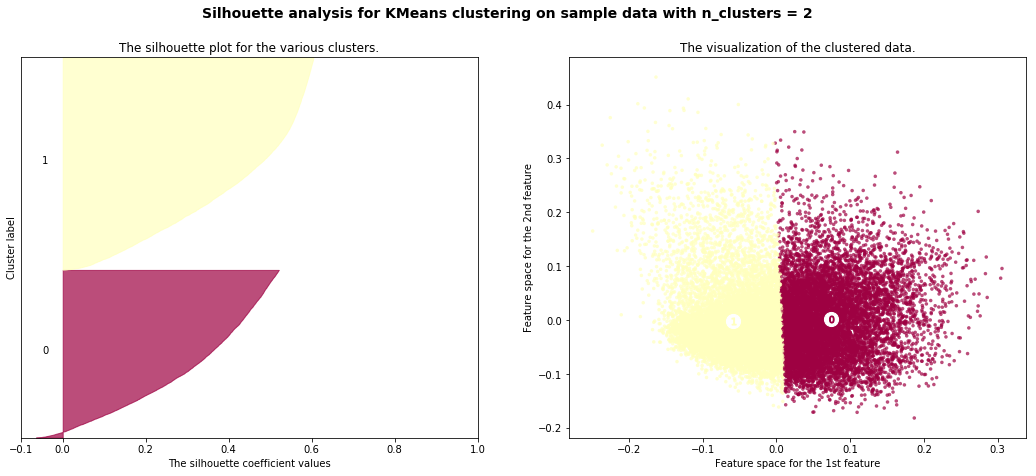

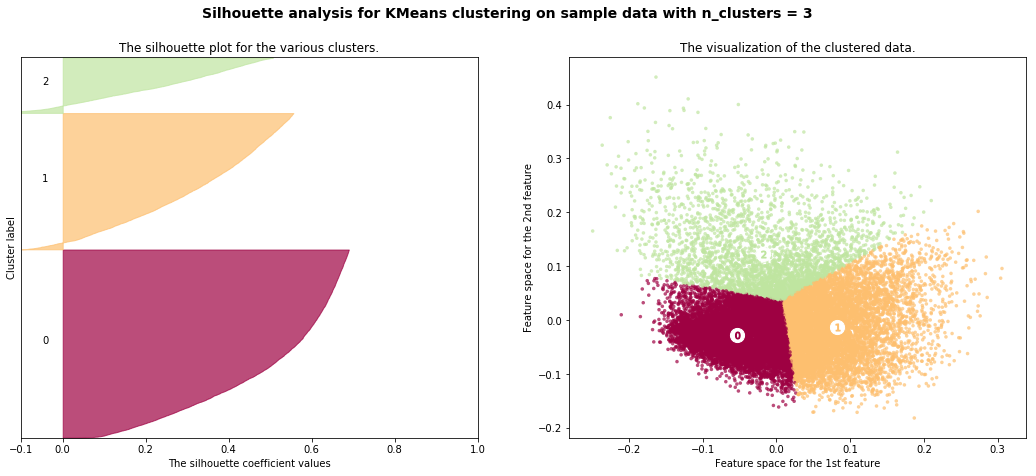

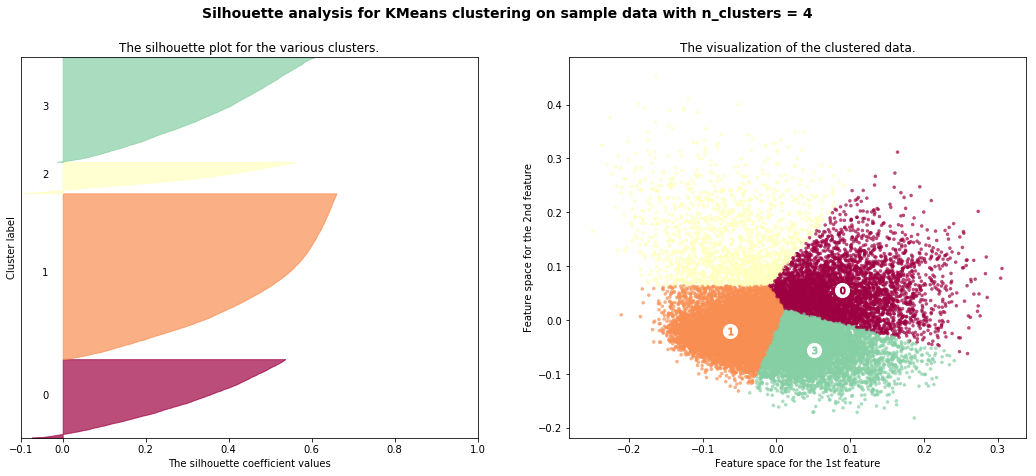

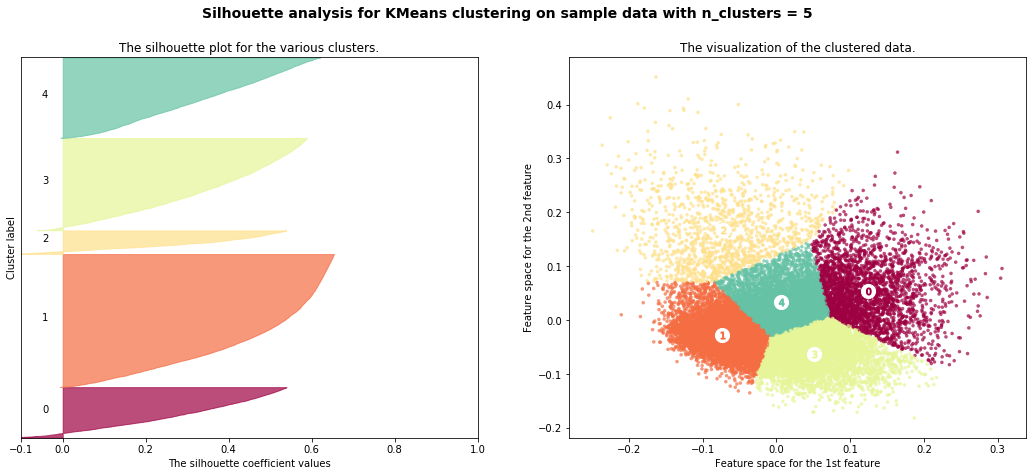

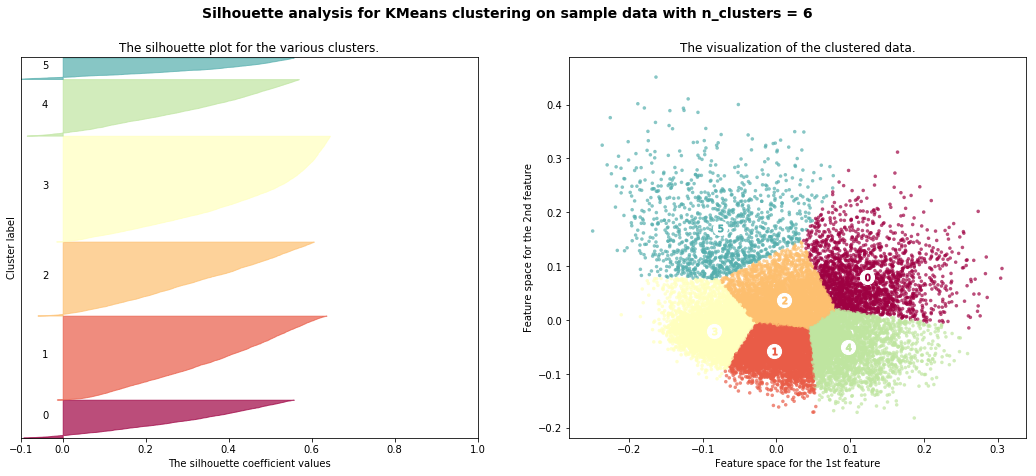

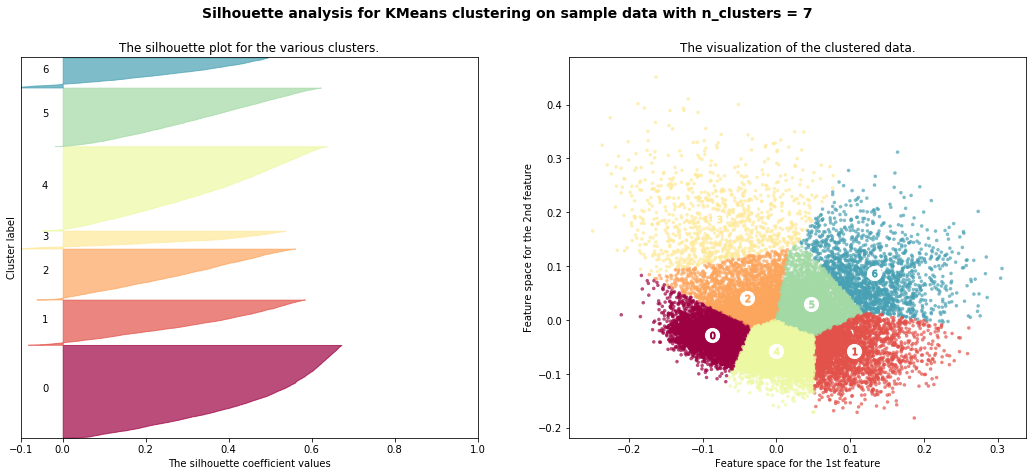

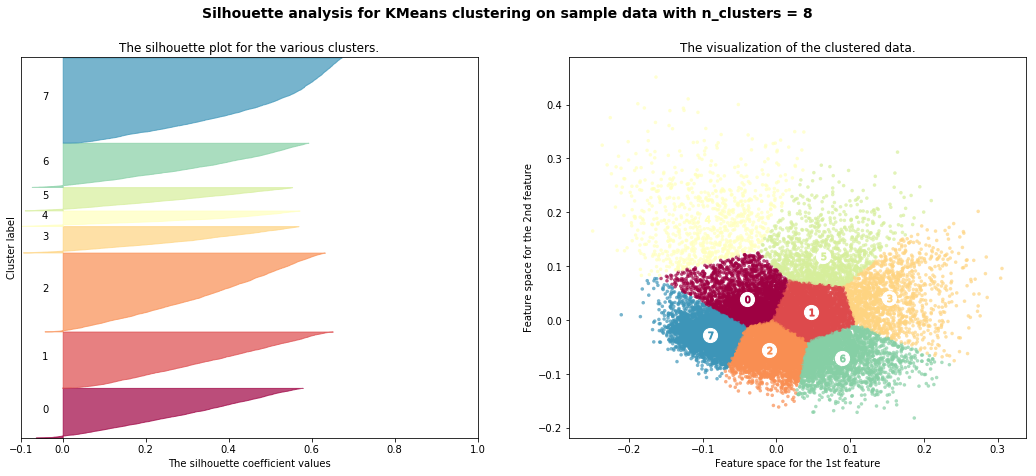

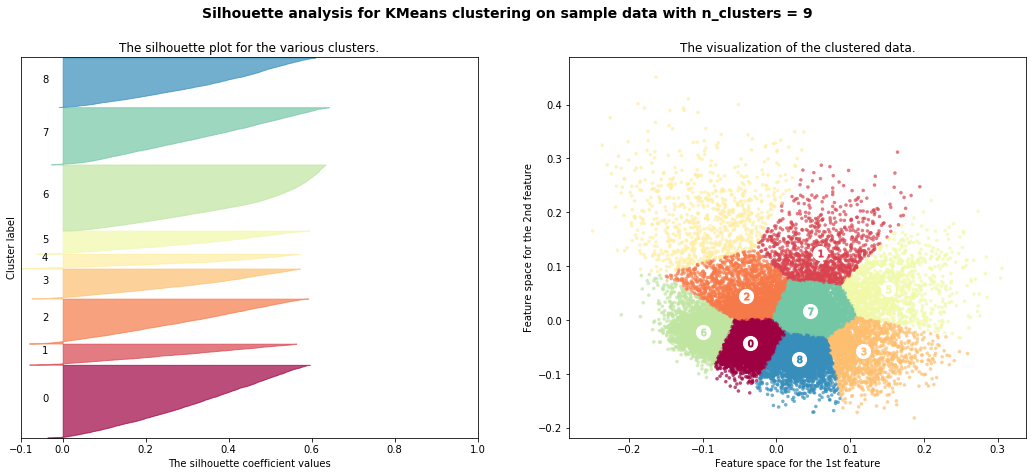

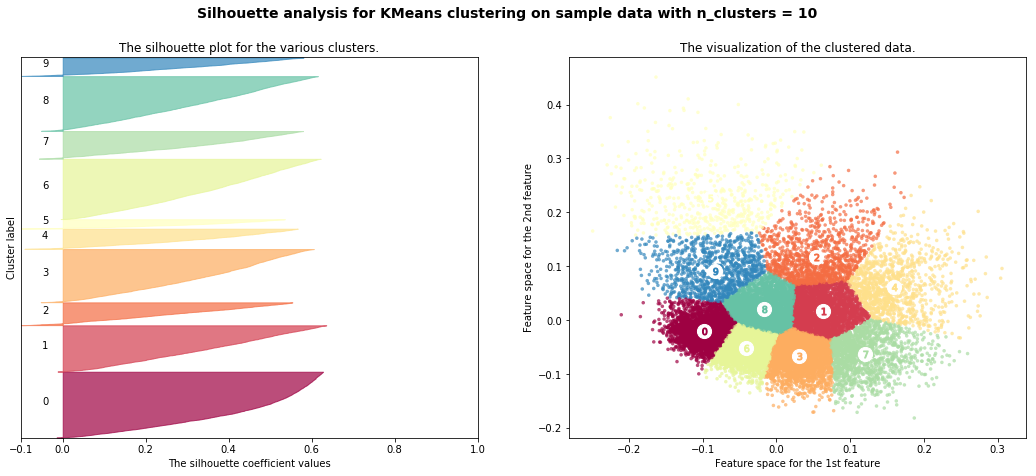

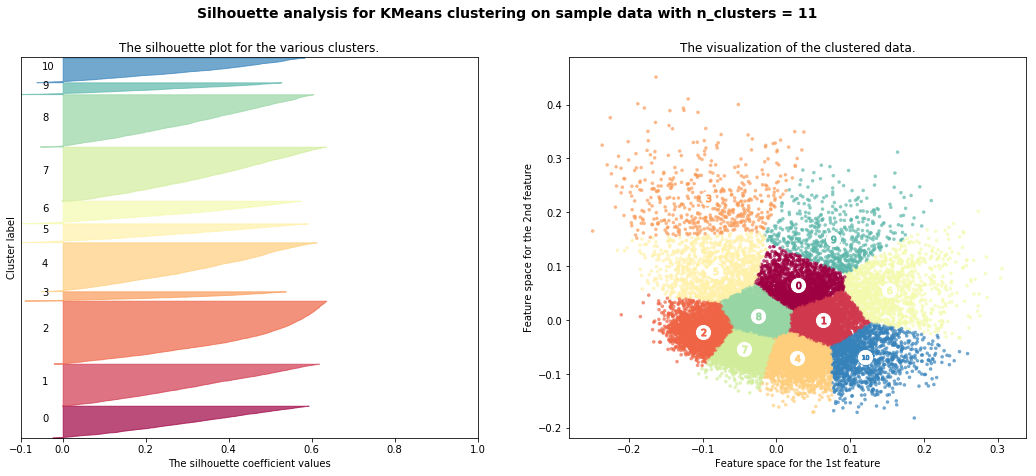

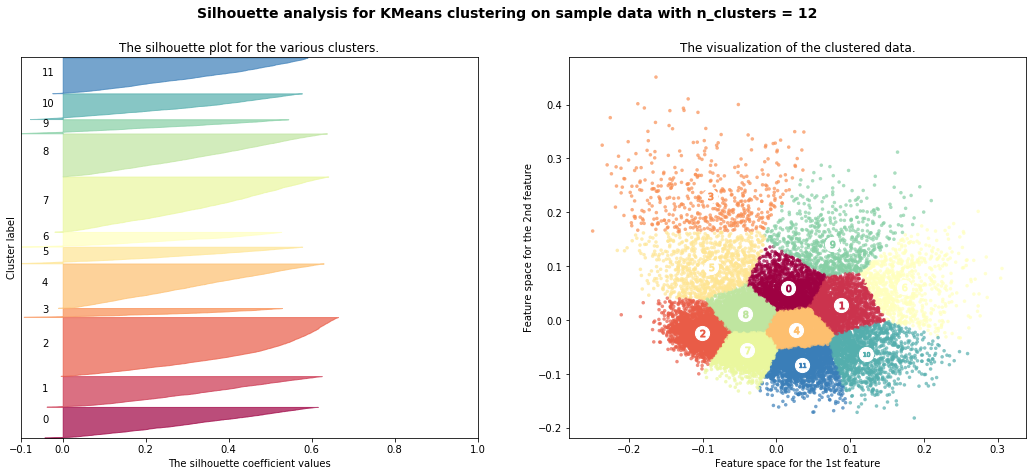

In [121]:
range_n_clusters = range(2, 13)
silhouette_scores = np.empty(shape=11)

for idx, n_clusters in enumerate(range_n_clusters):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    score = make_silhouette_plot(axs, X = pca_X_tv, n_clusters=n_clusters)
    silhouette_scores[idx] = score
    
    print(n_clusters)
    print(score)

Text(0, 0.5, 'silhouette score')

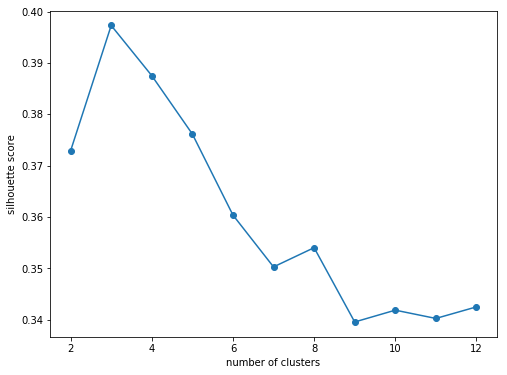

In [122]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range_n_clusters, silhouette_scores, 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("silhouette score")


In [211]:
nclusters = 3

In [212]:
km = KMeans(random_state=42, n_clusters=nclusters, n_jobs=-1)
km.fit(pca_X_tv)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [213]:
original_space_centroids = pca_tv.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [214]:
terms = stv.get_feature_names()
for i in range(nclusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind], end='')
    print('\n')

Cluster 0: peopl friend one would ask get like know say person think make feel work want help call go tell thank may someon pleas mani year way use husband day take need problem letter could love look good also see home thing school tri never talk give find women someth man

Cluster 1: husband want mother feel love year know get would children marri tell go famili friend like parent son daughter say relationship live father help wife think life make marriag one need talk old may man two ask work never tri see thing problem way told child move home take togeth

Cluster 2: gift wed mother daughter famili son invit parent children husband law would sister father child us ask one babi want brother parti thank marri give attend card home think live birthday send guest money mom year day shower receiv bride know old wife two feel pay plan friend say take



In [206]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(pca_X_tv, km.labels_, sample_size=1000))

print()

Silhouette Coefficient: 0.399



In [128]:
llabels = pd.concat([y, pd.Series(km.labels_, index=y.index)], axis=1)

In [ ]:
pred = llabels.loc[llabels[0] == 0, 'categories'].fillna('list()').apply(eval)

res = pd.DataFrame(mlb.fit_transform(pred),
                   columns=mlb.classes_,
                   index=pred.index)

res.sum(axis=0).idxmax()

In [346]:
pred = llabels.loc[llabels[0] == 1, 'categories'].fillna('list()').apply(eval)

res = pd.DataFrame(mlb.fit_transform(pred),
                   columns=mlb.classes_,
                   index=pred.index)

res.sum(axis=0).idxmax()

'Etiquette & Ethics'

In [347]:
pred = llabels.loc[llabels[0] == 2, 'categories'].fillna('list()').apply(eval)

res = pd.DataFrame(mlb.fit_transform(pred),
                   columns=mlb.classes_,
                   index=pred.index)

res.sum(axis=0).idxmax()

'Family & Parenting'

In [130]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [131]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [132]:
n_components= 3
n_top_words = 50

In [133]:
nmf = NMF(n_components=n_components, random_state=42,
          alpha=.1, l1_ratio=.5).fit(tfidf_df)

tfidf_feature_names = stv.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: husband friend want feel get year love know like would say go one peopl make tell think work ask help wife relationship marri may man need life marriag way talk person problem thing call tri see live never woman someon take day date good pleas could two find togeth home
Topic #1: gift wed invit parti card guest bride attend shower send thank would birthday receiv famili friend note give marri coupl plan money fianc celebr recept ask dinner etiquett host one groom pay christma buy ring sent us includ engag return ceremoni daughter expect sister proper holiday anniversari gave expens dress
Topic #2: mother daughter son parent father children child law sister mom famili babi dad brother old live boy kid girl want visit us home husband adult adopt would tell know told birth help young two sibl hous abus care rais age need away littl name support allow take school respons grandchildren



In [134]:
nmf = NMF(n_components=n_components, random_state=42,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_df)

tfidf_feature_names = stv.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: would year want think way tell say work one know like get make take feel tri woman thing pleas go may see two peopl talk well problem without told need wrong friend never love person someon help ask someth wife right still husband wonder togeth also could marri relationship use
Topic #1: would wed thank gift invit one us receiv use write send famili ask parti reader peopl letter thought attend money pay guest give plan wish mani home friend card husband mother sure suggest share sent includ return small day dinner note law birthday member proper put special howev recent offer
Topic #2: mother parent year son want children father old daughter child famili mom two young live sister law us husband visit wife kid dad told understand babi love brother home help younger three marri adult support girl need life sinc stay away boy ago rais respons littl hous refus wish worri



In [135]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)

lda.fit(count_df)
tf_feature_names = scv.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: peopl help one mani work need get school children know pleas letter may parent also person take could would make problem care doctor day reader health job life use famili find live thank child call inform like medic home dog learn abus read other way year go well becom import
Topic #1: would ask one friend say like wed husband gift think invit peopl want day get home make know way feel go famili us person call use tell take give money someon look come someth said pay parti dinner could even work thank wear may never howev rude card hous pleas
Topic #2: want feel husband year know mother would love get friend famili tell like go think say daughter marri live son relationship make parent one children may life old father wife talk two help need marriag told never thing tri see man ask way sister problem ago togeth date move month

